<a href="https://colab.research.google.com/github/ImNotDanish05/2025_Visi-Komputer_TI-2A/blob/main/Tugas03_TEKNIK-REGRESI-GAMBAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By: ImNotDanish05

# **Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)**

In [1]:
# @title 1) Setup & Generator Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

def add_noise_and_blur(img):
    # Blur dengan Gaussian kernel 5x5
    img_blur = cv2.GaussianBlur(img, (5,5), 0)

    # Noise Gaussian
    noise = np.random.normal(0, 0.2, img.shape).astype(np.float32)
    img_noisy = np.clip(img_blur + noise, 0, 1)  # pastikan tetap 0–1
    return img_noisy


# Generator 1 sample
def make_sample(img_size=64, min_r=8, max_r=28):
    r = np.random.randint(min_r, max_r + 1) # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r) # center-x
    cy = np.random.randint(r, img_size - r) # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)

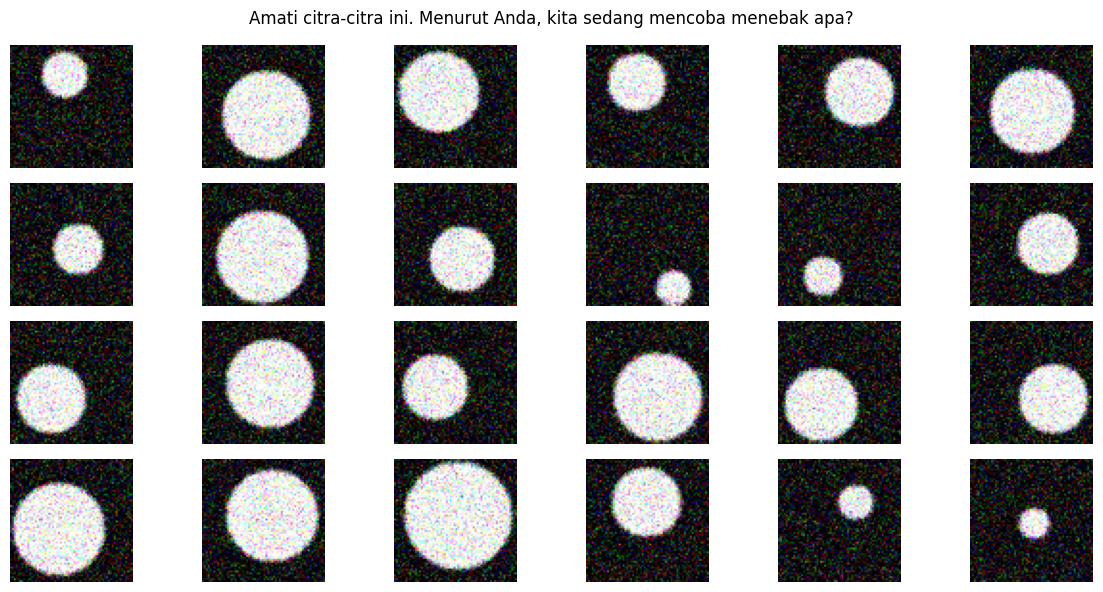

In [4]:
# @title 2) “Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
imgs_noisy = [add_noise_and_blur(s[0]) for s in samples]  # ✨ tambahkan noise di sini
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label (Disini kita akan nampilin versi noisy):
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

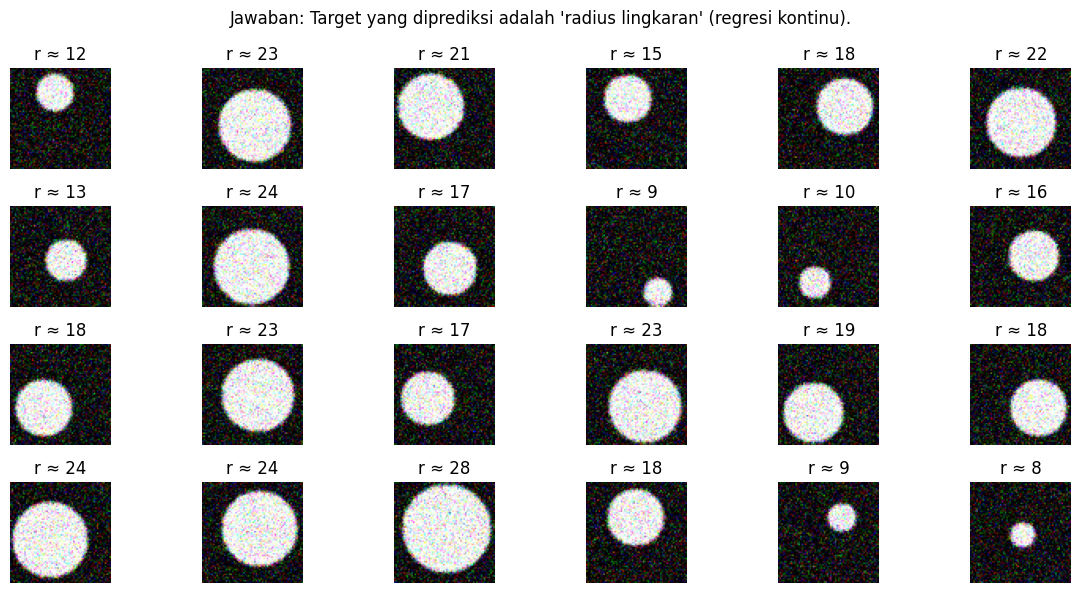

In [5]:
# @title 3) Buka Jawaban — Target yang Ingin Diprediksi
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
 plt.subplot(rows, cols, i+1)
 plt.imshow(imgs_noisy[i].squeeze(), cmap='gray')
 plt.title(f"r ≈ {int(rads[i])}")
 plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

In [6]:
# @title 4) (Opsional) Latih CNN Kecil untuk Memprediksi Radius

# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# ✅ Tambahkan noise di sini
X_noisy = np.array([add_noise_and_blur(x) for x in X], dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
MAE=0.718 | RMSE=0.922 | R²=0.977


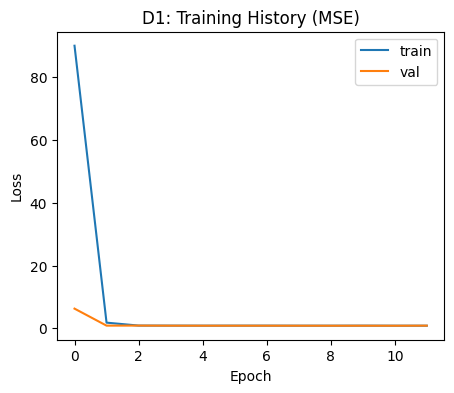

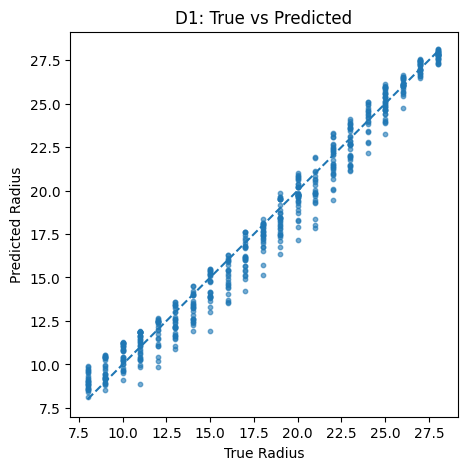

In [7]:
# @title Plot history & True vs Predicted:

# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

In [ ]:
# @title 5) Tantangan Mini (Opsional untuk Mahasiswa)
"""
• Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
• Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
• Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus;
metrik evaluasi apa yang cocok?
"""

# **Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)**

Pernahkah Anda memperhatikan wajah seseorang dan mencoba menebak usianya?
Mungkin dari garis senyum, bentuk rahang, atau tekstur kulit. Nah, komputer juga bisa
melakukan hal yang sama — dengan belajar dari ribuan contoh wajah berlabel umur.
Di praktikum ini, kita akan membuat sistem sederhana yang mampu memperkirakan umur
seseorang dari fotonya menggunakan teknik regresi gambar.

In [ ]:
# @title Langkah 1 — Membuat Akun Kaggle dan Mengunduh kaggle.json <br> Langkah 2 — Mengunggah kaggle.json ke Colab
from google.colab import files
import os

# Upload file (bisa file apa saja, misalnya kaggle-key.json)
print("Upload File Kagglenya!")
uploaded = files.upload()

# Ambil nama file pertama yang diupload
for filename in uploaded.keys():
    # Kalau ekstensi file-nya .json, kita rename jadi kaggle.json
    if filename.endswith('.json'):
        os.rename(filename, 'kaggle.json')
        print(f"File '{filename}' berhasil di-rename jadi 'kaggle.json' 🎉")
    else:
        print(f"File '{filename}' bukan file JSON, tidak di-rename.")


Upload File Kagglenya!


Saving token_api_kaggle.json to token_api_kaggle.json
File 'token_api_kaggle.json' berhasil di-rename jadi 'kaggle.json' 🎉


In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [ ]:
# @title Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


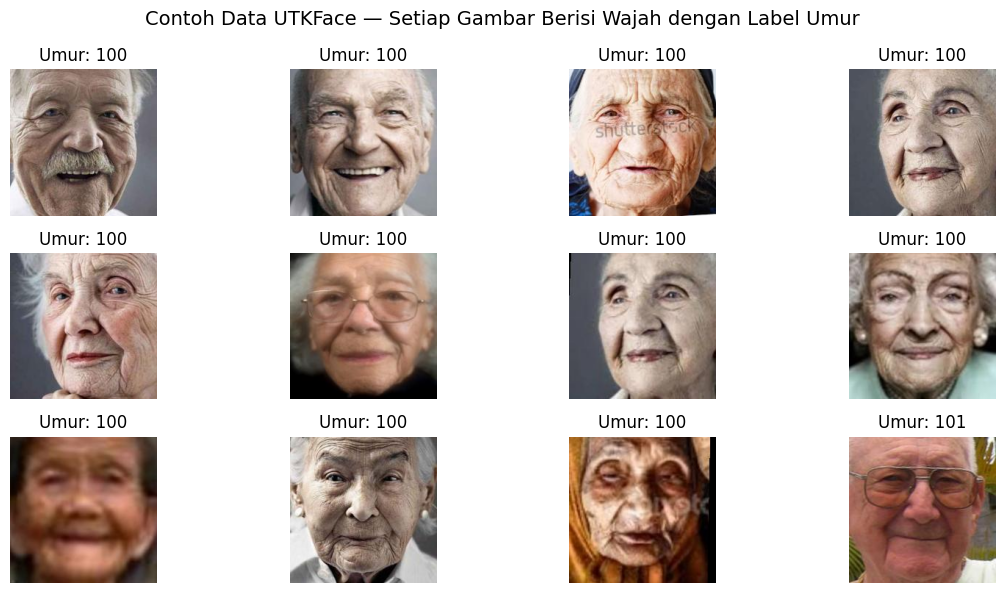

In [ ]:
# @title Langkah 4 — Menampilkan Contoh Gambar Dataset
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# @title Langkah 5 — Siapkan Dataset untuk Model
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
def parse_age_from_name(fp):
 return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
 files, ages, test_size=0.2, random_state=42
)
IMG_SIZE = 160
def load_img(fp, label):
 img = tf.io.read_file(fp)
 img = tf.image.decode_jpeg(img, channels=3)
 img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
 return img / 255.0, label
train_ds = tf.data.Dataset.from_tensor_slices((train_files,
y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,
y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [ ]:
# @title Langkah 6 — Membangun Model dengan Transfer Learning

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
  include_top=False,
  input_shape=(IMG_SIZE, IMG_SIZE, 3),
  weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 152ms/step - loss: 329.1557 - mae: 13.3237 - val_loss: 157.3204 - val_mae: 9.5379 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 154.3822 - mae: 9.2560 - val_loss: 145.9090 - val_mae: 9.0643 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 144.7902 - mae: 8.8948 - val_loss: 143.0164 - val_mae: 8.9345 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 141.0247 - mae: 8.7341 - val_loss: 138.8600 - val_mae: 8.7625 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - loss: 136.6383 - mae: 8.5786 - val_loss: 136.3764 - val_mae: 8.6315 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - loss: 133.6969 - mae: 8.4319 - val_loss: 134.5779 - val_mae: 8.5687 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 131.5108 - mae: 8.3978 - val_loss: 133.3574 - va

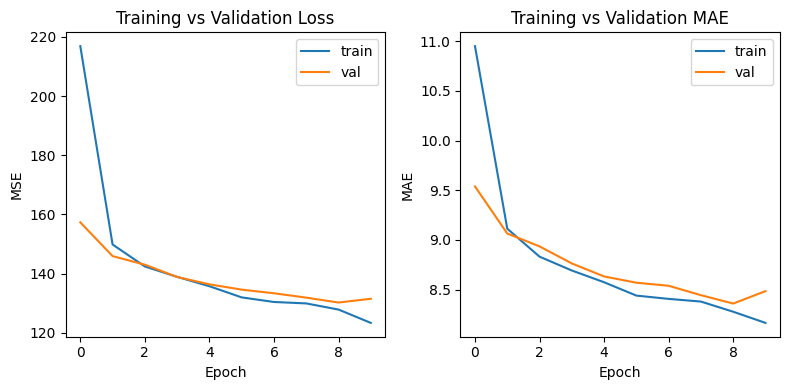

In [ ]:
# @title Langkah 7 — Melatih Model (Tahap 1 – Frozen)
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
    monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e5, monitor='val_loss')
]
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)
# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - loss: 189.0317 - mae: 10.1760 - val_loss: 191.1608 - val_mae: 10.1482 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 78.2482 - mae: 6.5972 - val_loss: 118.3023 - val_mae: 8.0984 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 51.7097 - mae: 5.3904 - val_loss: 112.7821 - val_mae: 7.7713 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 37.4018 - mae: 4.6456 - val_loss: 105.1155 - val_mae: 7.4487 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 30.6611 - mae: 4.1872 - val_loss: 121.6282 - val_mae: 7.7828 - learning_rate: 1.0000e-04


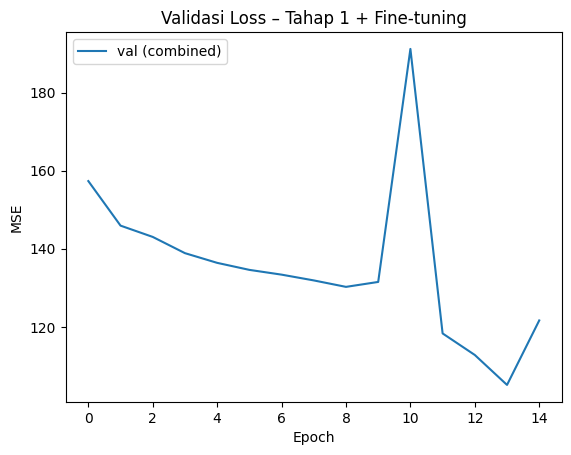

In [ ]:
# @title Langkah 8 — Fine-tuning Backbone (Tahap 2)

# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False # beku sebagian besar layer
# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='mse', metrics=['mae'])

history_ft = model.fit(
              train_ds,
              validation_data=test_ds,
              epochs=5,
              callbacks=cb,
              verbose=1
              )

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()


MAE = 7.45 tahun
RMSE = 10.25 tahun
R² = 0.735


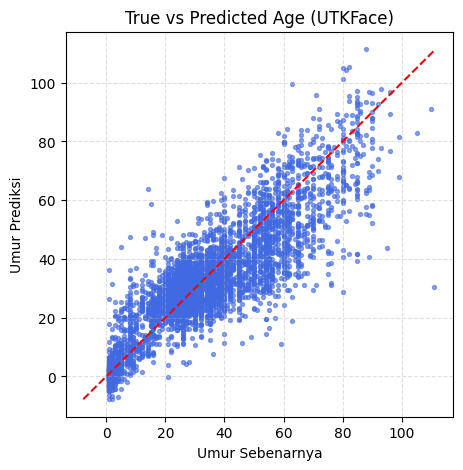

In [ ]:
# @title Langkah 9 — Evaluasi Akhir (MAE, RMSE, R²)

from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")
# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

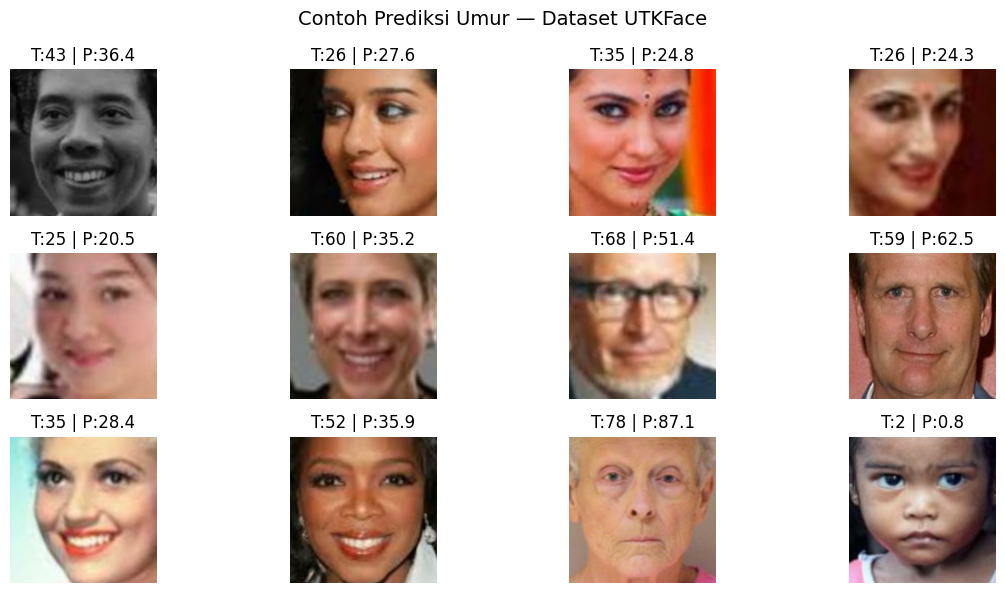

In [ ]:
# @title Langkah 10 — Melihat Contoh Prediksi Nyata
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# @title Tantangan Mini (Opsional)
"""
1. Tambahkan data augmentation ekstra (kontras, brightness, zoom).
→ Bagaimana pengaruhnya pada MAE?
2. Ubah learning rate schedule atau optimizer.
→ Apakah model lebih stabil?
3. Pisahkan dataset per kelompok umur (0–10, 11–20, dst).
→ Mana kelompok dengan error terbesar?
4. Uji model Anda pada wajah sendiri (setelah resize).
→ Apakah prediksinya realistis?
"""

# **Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto**

In [ ]:
# @title Langkah 1 — Membuat Akun Kaggle dan Mengunduh kaggle.json <br> Langkah 2 — Mengunggah kaggle.json ke Colab
from google.colab import files
import os

# Upload file (bisa file apa saja, misalnya kaggle-key.json)
print("Upload File Kagglenya!")
uploaded = files.upload()

# Ambil nama file pertama yang diupload
for filename in uploaded.keys():
    # Kalau ekstensi file-nya .json, kita rename jadi kaggle.json
    if filename.endswith('.json'):
        os.rename(filename, 'kaggle.json')
        print(f"File '{filename}' berhasil di-rename jadi 'kaggle.json' 🎉")
    else:
        print(f"File '{filename}' bukan file JSON, tidak di-rename.")


import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

In [ ]:
# @title Langkah 2 — Mengunduh dan Mengekstrak Dataset - Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

In [ ]:
# @title Langkah 3 — Melihat Contoh Data
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())
# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# @title Langkah 4 — Persiapan Dataset
from sklearn.model_selection import train_test_split
import tensorflow as tf
IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)
print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

In [ ]:
# @title Langkah 5 — Membangun Model (EfficientNetB0)
from tensorflow.keras import layers, models
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

In [ ]:
# @title Langkah 5 — Melatih Model
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3,
    restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=10,
callbacks=cb, verbose=1)

In [ ]:
# @title Langkah 6 — Melihat Proses Belajar
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# @title Langkah 7 — Evaluasi Model
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt
y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")
# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [ ]:
# @title Langkah 8 — Melihat Contoh Prediksi
import random
from PIL import Image
sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path,
    row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()
